<a href="https://colab.research.google.com/github/Gkulatheja/g_kulatheja/blob/master/Fall_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing necessary libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import os

### Extracting files from zip

In [ ]:
import zipfile
archieve = zipfile.ZipFile('/content/Fall.zip')
archieve.extractall()

## Reading train labels

In [ ]:
df_train = pd.read_csv('Fall/train_labels.csv', index_col='images')
df_train

,labels
images,
fall-02-cam1-rgb-001.jpg,0
fall-02-cam1-rgb-002.jpg,0
fall-02-cam1-rgb-003.jpg,0
fall-02-cam1-rgb-004.jpg,0
fall-02-cam1-rgb-005.jpg,0
...,...
fall-11-cam1-rgb-126.jpg,1
fall-11-cam1-rgb-127.jpg,1
fall-11-cam1-rgb-128.jpg,1


## Reading test labels

In [ ]:
test_df = pd.read_csv('Fall/test_labels.csv', index_col='images')
test_df

,labels
images,
fall-03-cam1-rgb-077.jpg,0
fall-03-cam1-rgb-093.jpg,0
fall-03-cam1-rgb-178.jpg,1
fall-03-cam1-rgb-196.jpg,1
fall-04-cam1-rgb-005.jpg,0
fall-04-cam1-rgb-042.jpg,1
fall-04-cam1-rgb-057.jpg,1
fall-17-cam1-rgb-068.jpg,1
fall-17-cam1-rgb-094.jpg,1


In [ ]:
# reading train and test images from the folder and stacking them while keep tracking of corresponding labels
dataset_folder = 'Fall'
train_images = []
train_labels = []
test_images = []
test_labels = []

for folder in os.listdir(dataset_folder):
    folder_path = os.path.join(dataset_folder, folder)
    if folder == 'train_images':
        for file in os.listdir(folder_path):
            if file.endswith('jpg'):
                img_path = os.path.join(folder_path, file)
                img = cv2.imread(img_path)
                train_images.append(img)
                train_labels.append(df_train.loc[file, 'labels'])

    elif folder == 'test_images':
        for file in os.listdir(folder_path):
            if file.endswith('jpg'):
                img_path = os.path.join(folder_path, file)
                img = cv2.imread(img_path)
                test_images.append(img)
                test_labels.append(test_df.loc[file, 'labels'])
    else:
        pass

train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)
print('Shape of stacked train images:', train_images.shape)
print('Shape of train labels:', train_labels.shape)
print('Shape of stacked test images:', test_images.shape)
print('Shape of test labels:', test_labels.shape)

Shape of stacked train images: (240, 96, 96, 3)
Shape of train labels: (240,)
Shape of stacked test images: (12, 96, 96, 3)
Shape of test labels: (12,)


## Visualizing some images together with their label to have an idea about our data

In [ ]:
# Function to convert binary label into text
def get_label(num):
    if num == 0:
        return 'NOT FALL'
    if num == 1:
        return 'FALL'
    else:
        return -1

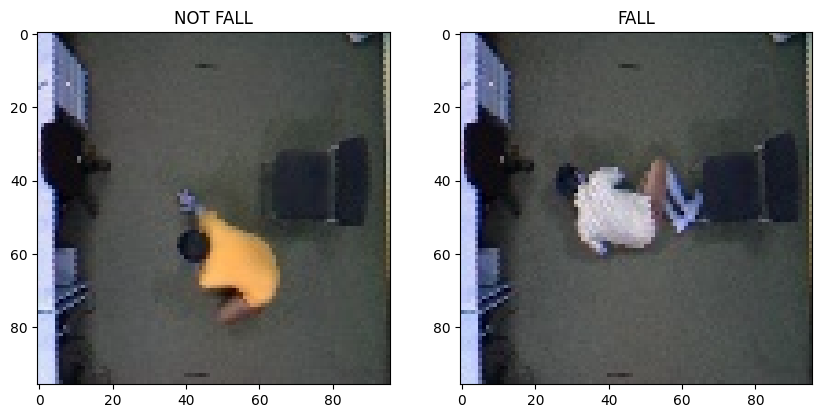

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 8), squeeze=False)
axes[0][0].imshow(train_images[2])
axes[0][0].set_title(get_label(train_labels[2]))

axes[0][1].imshow(train_images[3])
axes[0][1].set_title(get_label(train_labels[3]));

## Splitting our data into train and validation sets, building and training our model

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, stratify=train_labels, test_size=0.2)

In [ ]:
def conv2d(filters: int, name):
    return Conv2D(filters=filters, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.), bias_regularizer=l2(0.), name=name)

In [ ]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, ReLU
from tensorflow.keras.activations import sigmoid
from tensorflow.keras.regularizers import l2

# fallnet architecture
model_input = Input(shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]), name='inputs')

conv1 = conv2d(16, name='convoluton_1')(model_input)
act1 = ReLU(name='activation_1')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2), name='pooling_1')(act1)

conv2 = conv2d(16, name='convolution_2')(pool1)
act2 = ReLU(name='activation_2')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2), name='pooling_2')(act2)

conv3 = conv2d(32, name='convolution_3')(pool2)
act3 = ReLU(name='activation_3')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2), name='pooling_3')(act3)

conv4 = conv2d(32, name='convolution_4')(pool3)
act4 = ReLU(name='activation_4')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2), name='pooling_4')(act4)

conv5 = conv2d(64, name='convolition_5')(pool4)
act5 = ReLU(name='activation_5')(conv5)
pool5 = MaxPooling2D(pool_size=(2, 2), name='pooling_5')(act5)

conv6 = conv2d(64, name='convolution_6')(pool5)
act6 = ReLU(name='activation_6')(conv6)
pool6 = MaxPooling2D(pool_size=(2, 2), name='pooling_6')(act6)

flat = Flatten(name='flatten')(pool6)
dense1 = Dense(32, name='dense1')(flat)
output = Dense(1, activation='sigmoid', name='output')(dense1)

model = Model(inputs=[model_input], outputs=[output])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inputs (InputLayer)                  │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ convoluton_1 (Conv2D)                │ (None, 96, 96, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (ReLU)                  │ (None, 96, 96, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pooling_1 (MaxPooling2D)             │ (None, 48, 48, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ convolution_2 (Conv2D)               │ (None, 48, 48, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (ReLU)                  │ (None, 48, 48, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pooling_2 (MaxPooling2D)             │ (None, 24, 24, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ convolution_3 (Conv2D)               │ (None, 24, 24, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (ReLU)                  │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pooling_3 (MaxPooling2D)             │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ convolution_4 (Conv2D)               │ (None, 12, 12, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (ReLU)                  │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pooling_4 (MaxPooling2D)             │ (None, 6, 6, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ convolition_5 (Conv2D)               │ (None, 6, 6, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (ReLU)                  │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pooling_5 (MaxPooling2D)             │ (None, 3, 3, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ convolution_6 (Conv2D)               │ (None, 3, 3, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (ReLU)                  │ (None, 3, 3, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pooling_6 (MaxPooling2D)             │ (None, 1, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense1 (Dense)                       │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 74,193 (289.82 KB)

 Trainable params: 74,193 (289.82 KB)

 Non-trainable params: 0 (0.00 B)

### Visualizing out CNN Arhitecture with visualkeras Library

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 11.1 MB/s eta 0:00:00
Using LiberationSans-Regular.ttf as a fallback font.


/usr/local/lib/python3.10/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


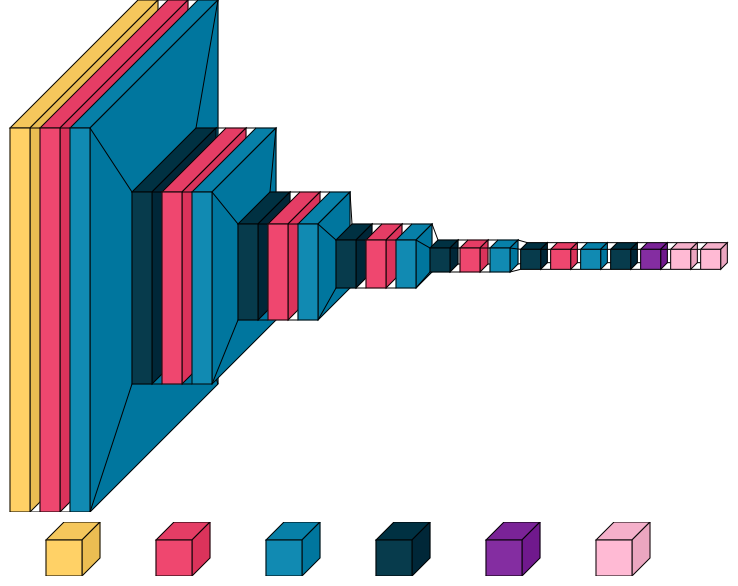

In [ ]:
!pip install visualkeras
import visualkeras
from PIL import ImageFont

# Try using a default font or provide the full path to arial.ttf if you have it
# If you have the font file, find its path using 'fc-list | grep arial.ttf'
try:
    # Attempt to use the 'arial.ttf' font if available
    font = ImageFont.truetype("arial.ttf", 32)
except OSError:
    # Fallback to a default font if 'arial.ttf' is not found
    try:
        font = ImageFont.truetype("LiberationSans-Regular.ttf", 32)
        print("Using LiberationSans-Regular.ttf as a fallback font.")
    except OSError:
        font = ImageFont.load_default()
        print("Using the default PIL font.")

visualkeras.layered_view(model, legend=True, font=font, to_file='fallnet_architecture.png')

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train,y_train, epochs = 6, validation_data = (X_val, y_val))

Epoch 1/6
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 304ms/step - accuracy: 0.6074 - loss: 22.1745 - val_accuracy: 0.5417 - val_loss: 0.7187
Epoch 2/6
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 228ms/step - accuracy: 0.5257 - loss: 0.6817 - val_accuracy: 0.4583 - val_loss: 0.6774
Epoch 3/6
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 231ms/step - accuracy: 0.5177 - loss: 0.6559 - val_accuracy: 0.5417 - val_loss: 0.5502
Epoch 4/6
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 381ms/step - accuracy: 0.7182 - loss: 0.4974 - val_accuracy: 0.9583 - val_loss: 0.2326
Epoch 5/6
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 505ms/step - accuracy: 0.9759 - loss: 0.2005 - val_accuracy: 0.9583 - val_loss: 0.1353
Epoch 6/6
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 448ms/step - accuracy: 0.9746 - loss: 0.0546 - val_accuracy: 1.0000 - val_loss: 0.0150


## Accuracy/Loss vs Epochs

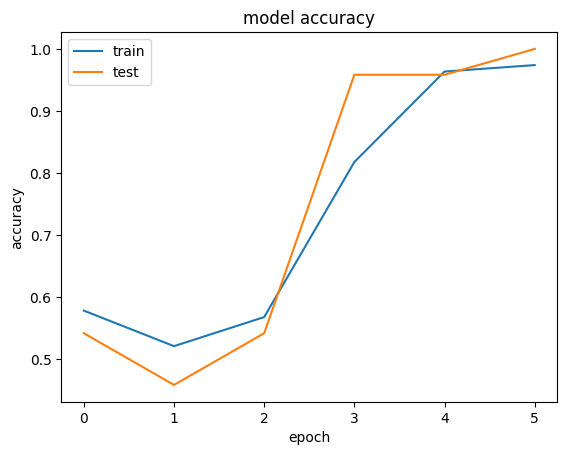

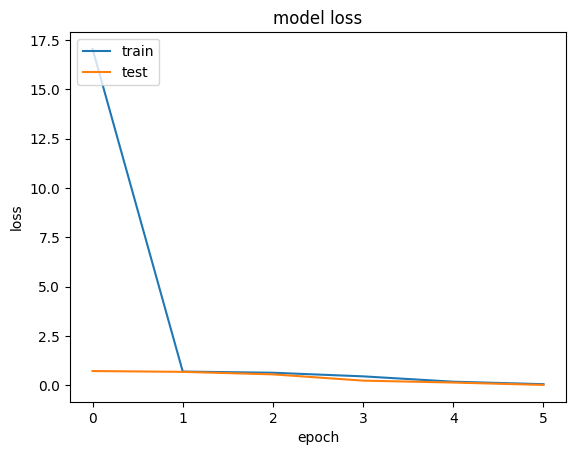

Weights saved.


In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

model.save('model.h5')
print('Weights saved.')

## Testing our model

In [ ]:
predicted_labels = (model.predict(test_images) >= 0.5).astype('int64').flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


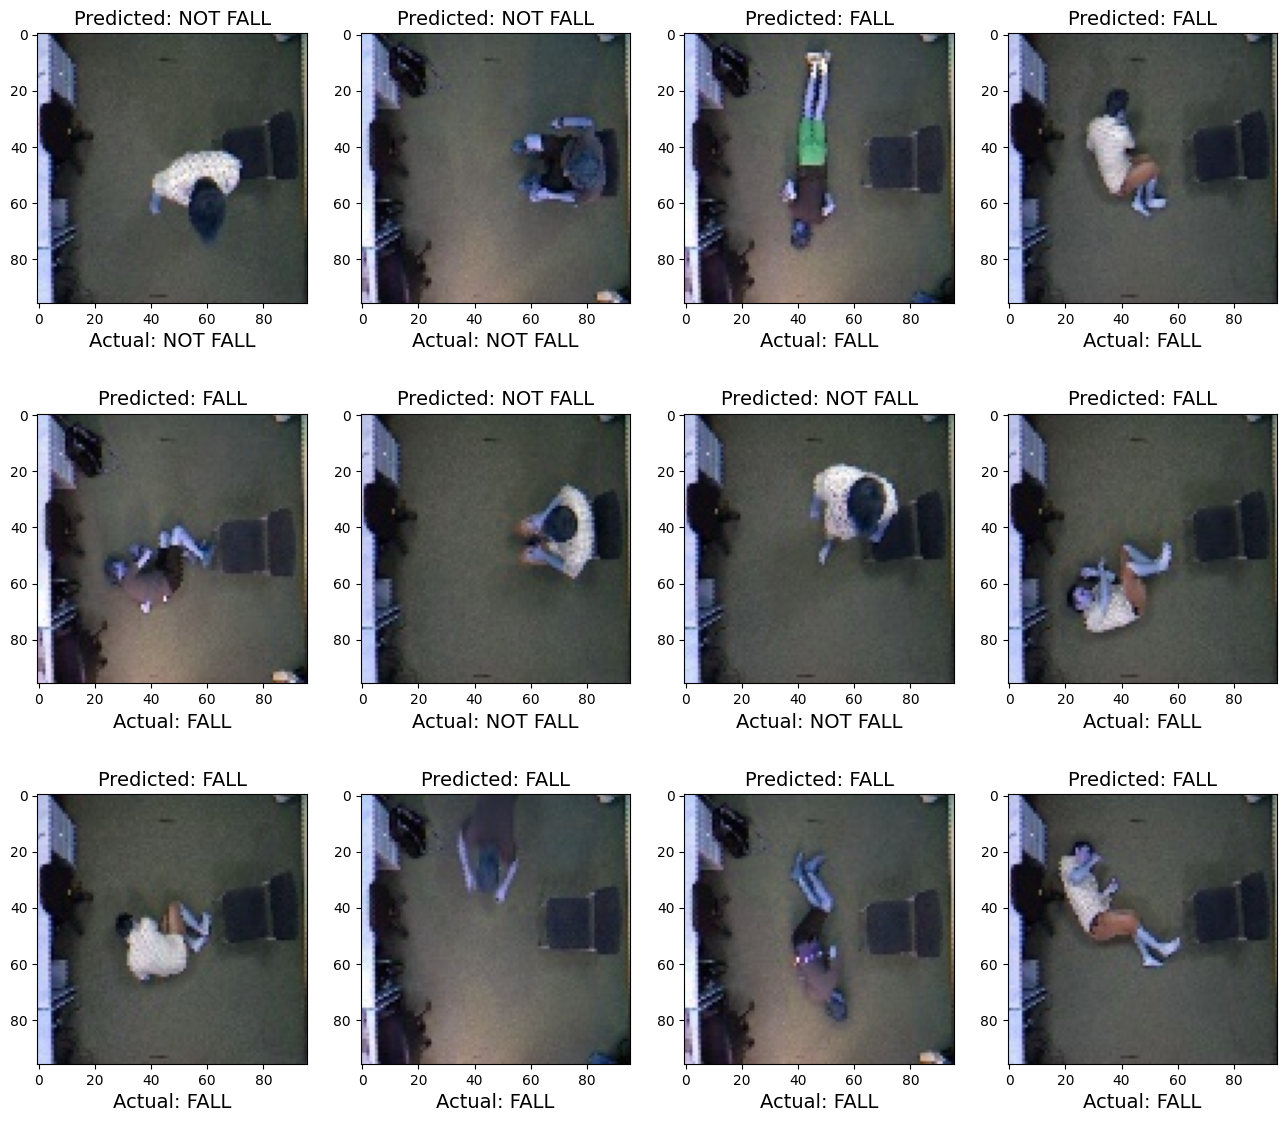

In [ ]:
# visualizing our results
row = 3
col = 4
fig, axes = plt.subplots(row, col, figsize=(16, 14))
c = 0
for i in range(row):
    for j in range(col):
        axes[i][j].imshow(test_images[c])
        axes[i][j].set_title(f'Predicted: {get_label(predicted_labels[c])}', fontsize=14)
        axes[i][j].set_xlabel(f'Actual: {get_label(test_labels[c])}', fontsize=14)
        c += 1